In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
# setup display parameters
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter

float_formatter = StrMethodFormatter("{x:0.03f}")
from IPython.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=(18, 6))  # set figure size

In [2]:
from abc import abstractmethod, ABC
from attrs import define, field
from random import random
from negmas import Mechanism, MechanismStepResult, Negotiator, PolyAspiration
from negmas import MechanismState, Preferences
from negmas import NegotiatorMechanismInterface
from typing import Callable, Tuple, Optional, List, Any, Dict
from negmas import (
    Outcome,
    make_issue,
    UtilityFunction,
    LinearUtilityFunction,
    ExpDiscountedUFun,
)
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

## Develop a new mechanism (protocol)

Developing a new mechanism for NegMAS is as easy as overriding a single method. In most cases though, a base class for 
negotiators compatible with this protocol needs to be created.

The algorithm for creating a new mechanism in `NegMAS` is simple:

1. Create a new `Mechanism` class and override the `round()` method to implement a single round of your protocol. 
   Optionally override the `__init__` function to provide a constructor to initialize your mechanism. Define any
   `requirements` of your mechanism that must be satisfied by negotiators using `add_requirements()` during construction
    (i.e. in the `__init__` method).
2. Create a new `Negotiator` class that has `abstractmethod(s)` for any methods called by your custom mechanism class
   (usually in the `round()` method). This will be the base class of all negotiators compatible with this new 
   mechanism. Set any *capabilities* for this new negotiator base class in its `__init__` method using 
   `add_capabilities()` 
3. Optionally create a new `MechanismState` `dataclass` with any extra state information that the mechanism will pass to
   negotiators and override the `extra_state()` method of your mechanism class to return a dict representation of this
   extra state (you will see an example later in this tutorial). Moreover, you will need to change the `state_factory` 
   argument passed to the `Mechechanism` constructor to use this newly created state type. This step is optional 
   and is only needed if extra-state needs to be passed to negotiators through the `state` method. It t is recommended 
   to keep all variable publicly accessible information of the mechanism in its state variable. This way, the history of
   the mechanism state will be accessible through the `history` property after the mechanism run.

### Nash Bargaining Game (Stateless Mechanism)
Let's start by developing one of the earliest negotiation protocols every proposed: **Nash Bargaining Game (1950)** .

The Nash bargaining game is a single-step full-information bilateral negotiation with $\Omega = [0, 1]^2$ and two 
 utility functions ($\tilde u_1, \tilde u_2$) such that:
 - A (usually convex) feasible set of agreements $F$. A common example is to define $F$ as all the outcomes for which 
   the total utility received by negotiators is less than or equal to one:
   
   $$F = \left\{(\omega_1, \omega_2) | \tilde u_2(\omega_2) + \tilde u_1(\omega_1) \le 1\right\}$$.
   
 - A disagreement point $d \equiv  \tilde u_1(\phi) + \tilde u_2(\phi) \in \Re^2$ which is the utility value received by the two players in case of disagreement (
   reserved values) and $\phi$ represents the disagreement.
 

In [3]:
class NashBargainingGame(Mechanism):
    """A mechanism representing the nash bargaining game"""

    def __init__(self, **kwargs):
        kwargs.update(dict(n_steps=1, max_n_negotiators=2, dynamic_entry=False))
        super().__init__(**kwargs, issues=[make_issue((0.0, 1.0))])
        self.add_requirements(dict(propose_for_self=True))
        self.ufuns: List[UtilityFunction] = []

    def add(
        self,
        negotiator: Negotiator,
        *,
        preferences: Preferences | None = None,
        **kwargs,
    ) -> Optional[bool]:
        added = super().add(negotiator, preferences=preferences, role=None, **kwargs)
        if added:
            self.ufuns.append(self.negotiators[-1].ufun)

    def is_feasible(self, outcome: Tuple[float]):
        """Tests feasibility of outcomes.

        The default implementation tests that the of all utilities assigned to all negotiators is less than 1.0.
        """
        return sum(u(outcome) for u in self.ufuns) <= (1.0 + 1e-3)

    def __call__(self, state, action=None) -> MechanismStepResult:
        """One round of the mechanism"""
        if len(self.negotiators) != 2:
            state.has_error = True
            state.error_details = f"Got {len(self.negotiators)} negotiators!!"
            state.broken = True
            return MechanismStepResult(state=state)
        outcome = tuple(
            n.propose_for_self(self.ufuns, i) for i, n in enumerate(self.negotiators)
        )
        if self.is_feasible(outcome):
            state.agreement = outcome
        return MechanismStepResult(state=state)

The implementation is straight forward. We need to define what a round of the algorithm does (`round()` ). In this
case we used `is_feasible()` to distinguish feasible and infeasible outcomes.

We need now to develop a base class for negotiators compatible with this mechanism.

In [4]:
class NashBargainingNegotiator(Negotiator, ABC):
    """Base class of all negotiators capable of negotiating in the nash bargaining game"""

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.add_capabilities(dict(propose_for_self=True))

    @abstractmethod
    def propose_for_self(self, ufuns: List[UtilityFunction], my_indx: int) -> float:
        """Propose some outcome which is just a real number"""

Note that any agreement with utilities that sum to the maximum possible value within the feasible space is a nash 
equilibrium to this game and is pareto-efficient.

Based on the axioms used to represent rationality, there are three widely known equilibria for the Nash bargaining game:

- Nash Point (1950): The point at which the product of surplus utility (above reservation value) of negotiators is maximized
 
$$\text{argmax}_{\omega_1, \omega_2} \prod_{i=1}^2\left(\tilde u_i(\omega_{i}) - \tilde u_i(\phi)\right)$$

- Kalai-Smorodinsky Point (1975): The pareto outcome with equal ratios of achieved  surplus utility and  maximum feasible 
surplus utility

$$\text{argmax}_{\omega_1, \omega_2 \in F}\left(\omega_1+\omega_2\right) 
\text{ s.t. }
\left(\frac{\tilde u_1(\omega_1)-\tilde u_1(\phi)}{\tilde u_2(\omega_2)-\tilde u_2(\phi)} = 
\frac{\max_{v \in F} \left(\tilde u_1(v)\right)-\tilde u_1(\phi)}{\max_{v \in F} 
\left(\tilde u_2(v)\right)-\tilde u_2(\phi)}\right)$$

- Kalai Point (1977): The pareto outcome maximizing the utility for the unfortunate player. Defining $P$ as the pareto
front,

$$\text{argmax}_{\omega_1, \omega_2 \in P} \min_{i \in \{1,2\}}\left(\tilde u_i(\omega_{i}) - \tilde u_i(\phi)\right)$$

We will not implement a negotiator that plays the nash-point strategy with no prior knowledge of the utility function
structure (i.e. it works for nonlinear nonconvex utility functions).

In [5]:
class NashNegotiator(NashBargainingNegotiator):
    """Implements Nash solution to the bargaining game"""

    def propose_for_self(self, ufuns: List[UtilityFunction], my_indx: int) -> float:
        objective = lambda f0: -(ufuns[0]((f0, 1.0 - f0)) - ufuns[0].reserved_value) * (
            ufuns[1]((f0, 1.0 - f0)) - ufuns[1].reserved_value
        )
        while True:
            result = minimize(objective, x0=[random()], bounds=[(0.0, 1.0)])
            if result.success:
                break
        return float(result.x[0]) if my_indx == 0 else 1.0 - float(result.x[0])

Now let's try our brand new mechanism and negotiator

In [6]:
m = NashBargainingGame()
u1 = LinearUtilityFunction([1, 0], reserved_value=0.0, outcome_space=m.outcome_space)
u2 = LinearUtilityFunction([0, 1], reserved_value=0.0, outcome_space=m.outcome_space)
m.add(NashNegotiator(ufun=u1, name="a1"))
m.add(NashNegotiator(ufun=u2, name="a2"))
result = m.run()
print(f"Agreement: {result.agreement}")

Agreement: (0.5000000026607994, 0.4999999976924583)


As expected, the two negotiators agreed on the expected nash point (0.5, 0.5) from the first trial.

It is possible to see what happens at different other conditions. For example, how does the reservation value affect 
the outcome: 

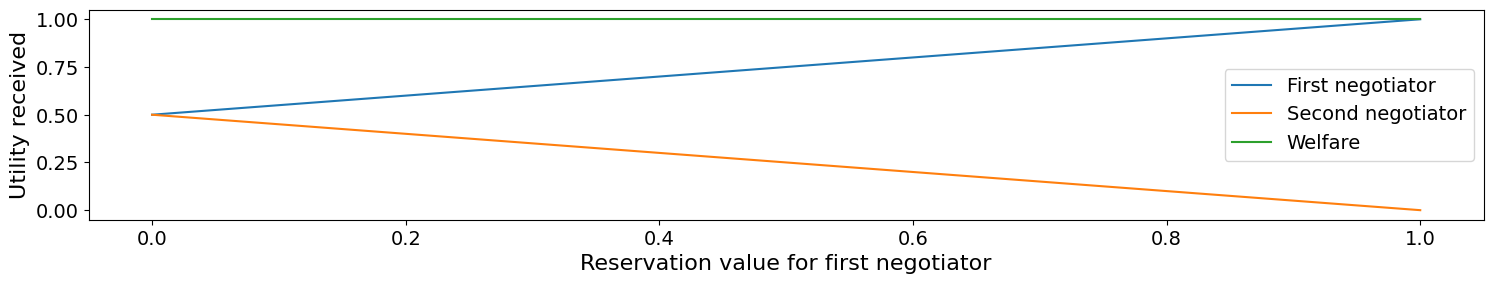

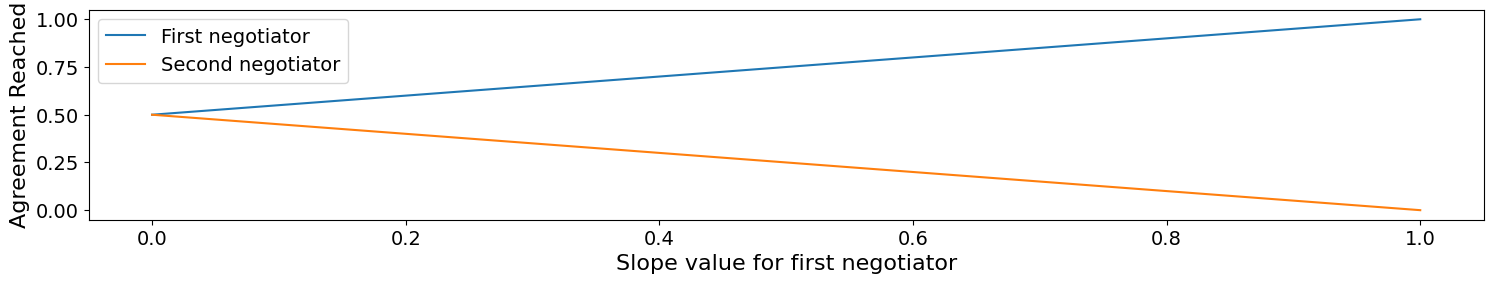

In [7]:
u1values, u2values = np.zeros(101), np.zeros(101)
a1values, a2values = np.zeros(101), np.zeros(101)
values = np.linspace(0.0, 1.0, 101, endpoint=True)
for i, r in enumerate(values):
    m = NashBargainingGame()
    u1 = LinearUtilityFunction([1, 0], reserved_value=r, outcome_space=m.outcome_space)
    u2 = LinearUtilityFunction(
        [0, 1], reserved_value=0.0, outcome_space=m.outcome_space
    )
    m.add(NashNegotiator(ufun=u1, name="a1"))
    m.add(NashNegotiator(ufun=u2, name="a2"))
    result = m.run()
    u1values[i] = u1(result.agreement)
    u2values[i] = u2(result.agreement)
    a1values[i], a2values[i] = result.agreement
plt.subplot(211)
plt.plot(values, u1values, label="First negotiator")
plt.plot(values, u2values, label="Second negotiator")
plt.plot(values, u1values + u2values, label="Welfare")
plt.ylabel("Utility received")
plt.legend()
plt.xlabel("Reservation value for first negotiator")
plt.show()

plt.subplot(212)
plt.plot(values, a1values, label="First negotiator")
plt.plot(values, a2values, label="Second negotiator")
plt.ylabel("Agreement Reached")
plt.legend()
plt.xlabel("Slope value for first negotiator")
plt.show()

 We can see that increasing the reservation value of a negotiator increases the utility it receives by the end of the 
 negotiation proportionally.  

What happens if the utility value of a negotiator had a different slope:

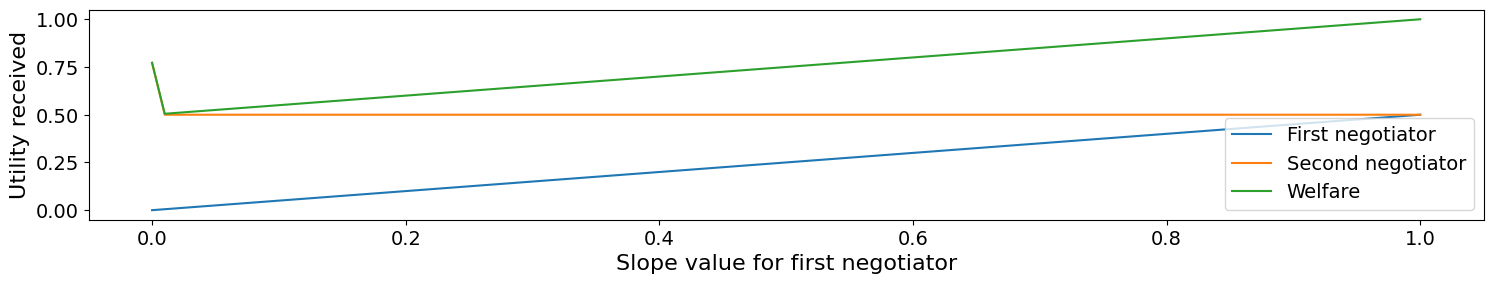

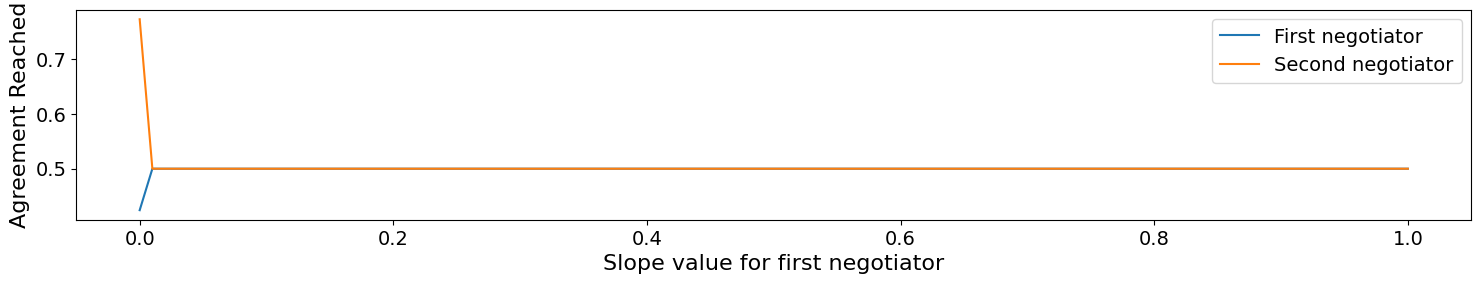

In [8]:
u1values, u2values = np.zeros(101), np.zeros(101)
a1values, a2values = np.zeros(101), np.zeros(101)
slopes = np.linspace(0.0, 1.0, 101, endpoint=True)
for i, s in enumerate(slopes):
    m = NashBargainingGame()
    u1 = LinearUtilityFunction(
        [s, 0], reserved_value=0.0, outcome_space=m.outcome_space
    )
    u2 = LinearUtilityFunction(
        [0, 1], reserved_value=0.0, outcome_space=m.outcome_space
    )
    m.add(NashNegotiator(ufun=u1, name="a1"))
    m.add(NashNegotiator(ufun=u2, name="a2"))
    result = m.run()
    u1values[i], u2values[i] = u1(result.agreement), u2(result.agreement)
    a1values[i], a2values[i] = result.agreement

plt.subplot(211)
plt.plot(slopes, u1values, label="First negotiator")
plt.plot(slopes, u2values, label="Second negotiator")
plt.plot(slopes, u1values + u2values, label="Welfare")
plt.ylabel("Utility received")
plt.legend()
plt.xlabel("Slope value for first negotiator")
plt.show()

plt.subplot(212)
plt.plot(slopes, a1values, label="First negotiator")
plt.plot(slopes, a2values, label="Second negotiator")
plt.ylabel("Agreement Reached")
plt.legend()
plt.xlabel("Slope value for first negotiator")
plt.show()

Notice that in this case, the both negotiators always get their maximum possible utility which leads to a linear increase in 
welfare with slope. There is a small exception though at slope zero.  Try running the last simulation
several times. Does the peculiar result at slope zero persist? Does it lead to the same welfare every time? 
Can you explain it?

### Rubinstein Bargaining Protocol (Stateful Mechanism)

Rubinstein provided one of the earliest and most widely cited results for multi-round bilateral negotiation.

In this protocol, two negotiators are again trying to find an agreement each maximizing its own utility. This is a full
information game in which the utility function of both agents is common knowledge. Moreover, there is some discount 
mechanism that reduces the utility of any potential agreement over time which is different for the two negotiators but 
is also known. In this tutorial we will focus on the case with exponential discounting (with with $t$  representing 
round number and $\delta_i$ is the discount factor for negotiator $i$). Throughout this section we will use superscripts to indicate round number. Moreover, we will focus on the case where the
initial utility of an agreement is the value assigned to the agent in that agreement:

$$\tilde u_i^t(\omega) = \delta_i^t \omega_i$$

We can start by designing the `MechanismState` class corresponding to this information.

In [9]:
@define
class RubinsteinMechanismState(MechanismState):
    discounts = field(factory=list)

We can then define the mechanism class itself:


In [10]:
class RubinsteinMechanism(Mechanism):
    """Simplified Rubinstein's Mechanism with Exponential discounting"""

    def __init__(self, extended=False, **kwargs):
        kwargs.update(
            dict(
                issues=[
                    make_issue(values=(0.0, 1.0), name="first"),
                    make_issue(values=(0.0, 1.0), name="second"),
                ],
                max_n_negotiators=2,
                dynamic_entry=False,
                initial_state=RubinsteinMechanismState(),
            )
        )
        super().__init__(**kwargs)
        self.add_requirements(dict(propose=True, set_index=True))
        self.state.discounts = []
        self.proposals = []
        self.extended = extended

    def add(
        self, negotiator: "Negotiator", *, discount: float = 0.95, **kwargs
    ) -> Optional[bool]:
        weights = [1, 0] if len(self.negotiators) == 0 else [0, 1]
        ufun = ExpDiscountedUFun(
            LinearUtilityFunction(weights, outcome_space=self.outcome_space),
            outcome_space=self.outcome_space,
            discount=discount,
        )
        added = super().add(negotiator, ufun=ufun, role=None, **kwargs)
        if added:
            self.state.discounts.append(discount)

    def __call__(self, state, action=None) -> MechanismStepResult:
        """One round of the mechanism"""
        if state.step == 0:
            if len(self.negotiators) != 2:
                state.error = (True,)
                state.error_details = (f"Got {len(self.negotiators)} negotiators!!",)
                state.broken = (True,)
                return MechanismStepResult(state=state)
            for i, n in enumerate(self.negotiators):
                n.set_index(i)
        outcomes = list(n.propose(self.state) for n in self.negotiators)
        self.proposals.append(outcomes)
        if any(o is None for o in outcomes):
            state.broken = True
            return MechanismStepResult(state=state)
        if sum(outcomes[0]) <= 1 + 1e-3:
            if self.extended:
                # If each negotiators offered itself nothing more than what its
                #  partner is offering it, this is an agreement with each negotiator
                #  getting what it offered itself. This is not a part of the
                #  Rubinstein protocol (hence extended). It was added to avoid
                #  very long negotiations as the original mechanism is supposed to
                #  allow an infinite time.
                if (
                    outcomes[0][0] <= outcomes[1][0] + 1e-5
                    and outcomes[1][1] <= outcomes[0][1] + 1e-5
                ):
                    state.agreement = (
                        min(outcomes[0][0], outcomes[1][0]),
                        min(outcomes[0][1], outcomes[1][1]),
                    )
                    return MechanismStepResult(state=state)
            elif max(abs(outcomes[0][i] - outcomes[1][i]) for i in range(2)) < 1e-3:
                # If both negotiators offer the same division of the pie (approximately),
                #  that is an agreement. This is the only method to end the run in the
                #  original Rubinstein protocol.
                state.agreement = tuple(
                    0.5 * (outcomes[0][i] + outcomes[1][i]) for i in range(2)
                )
                return MechanismStepResult(state=state)

        return MechanismStepResult(state=state)

The mechanism is very similar to the Nash Bargaining Game with few modifications:

1. The `add()` method now creates the utility function for the negotiator following the rules of the game. Each
   negotiator receives an exponentially discounted utility function of the portion it receives from the pie.
1. We expand `state` to provide the `discounts` values.   
1. `propose()` in the negotiators is expected to receive a state of type `RubinsteinMechanismState` .
1. Each round all negotiators propose outcomes and the negotiation terminates with success only if both proposals are
   feasible (sum to no more than 1.0) and equal (approximately)

We can now develop the base negotiator type for this mechanism:

In [11]:
class RubinsteinNegotiator(Negotiator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.add_capabilities(dict(propose=True, set_index=True))
        self.my_index = -1

    def set_index(self, indx: i) -> None:
        self.my_index = indx

    @abstractmethod
    def propose(
        self, state: RubinsteinMechanismState, dest: str | None = None
    ) -> Outcome:
        """Proposes an outcome which is a tuple of two numbers between zero and one"""

The base negotiator here implements `set_index` so that specific negotiators need not bother about it. It defines a single abstract method to be overridden by any compatible negotiator.

We will first define a utility function to plot what happens in a negotiation


In [12]:
def plot_a_run(mechanism: RubinsteinMechanism) -> None:
    result = mechanism.state
    x = np.linspace(0.0, 1.0, 101, endpoint=True)
    first = np.array([_[0] for _ in mechanism.proposals])
    second = np.array([_[1] for _ in mechanism.proposals])
    plt.plot(x, 1 - x, color="gray", label="Pareto-front")
    plt.xlabel("Agent 1's utility")
    plt.ylabel("Agent 2's utility")
    plt.scatter(
        first[:, 0], first[:, 1], marker="x", color="green", label="Proposals from 1"
    )
    plt.scatter(
        second[:, 0], second[:, 1], marker="+", color="blue", label="Proposals from 2"
    )
    if result.agreement is not None:
        plt.scatter(
            [result.agreement[0]],
            [result.agreement[1]],
            marker="o",
            color="red",
            label="Agreement",
        )
    plt.legend()
    plt.show()

Let's implement a random negotiator that ends the negotiation if it finds that it is impossible to get a positive 
utility anymore (due to discounting) and otherwise returns a random apportionment of the pie.

In [13]:
class RandomRubinsteinNegotiator(RubinsteinNegotiator):
    def propose(
        self, state: RubinsteinMechanismState, dest: str | None = None
    ) -> Outcome:
        if self.ufun((1.0, 1.0)) < 0.0:
            return None
        r = random()
        return r, 1 - r

Now we can run negotiations using our new protocol and negotiator:

Agreed to: (0.970350465903039, 0.029649534096961028) after 1304 steps


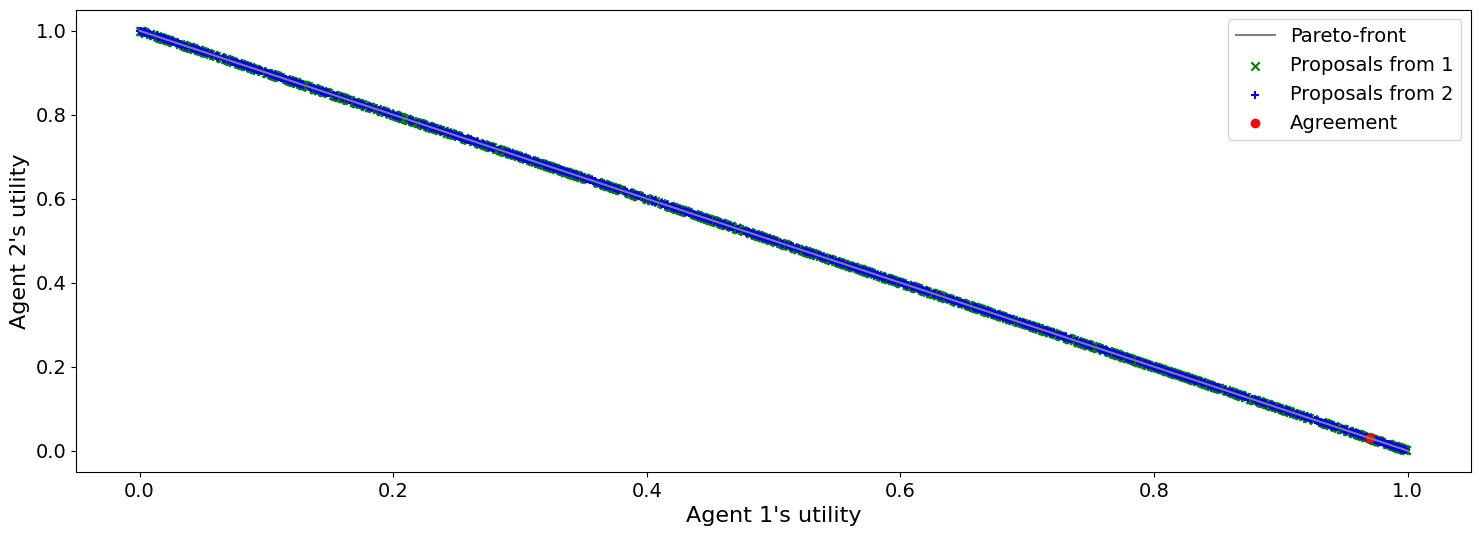

In [14]:
mechanism = RubinsteinMechanism()
mechanism.add(RandomRubinsteinNegotiator(), discount=0.75)
mechanism.add(RandomRubinsteinNegotiator(), discount=0.75)
print(f"Agreed to: {mechanism.run().agreement} after {mechanism.current_step} steps")
plot_a_run(mechanism)

Rubinstein showed in 1982 that there is a single perfect game equilibrium  of single round that takes the form:

$$\left(\frac{1-\delta_2}{1-\delta_1\delta_2}, \frac{\delta_2\left(1-\delta_1\right)}{1-\delta_1\delta_2}\right)$$

We can implement the optimal negotiator for this mechanism as follows:

Agreed to: (0.5128205128205131, 0.4871794871794869) in 1 steps


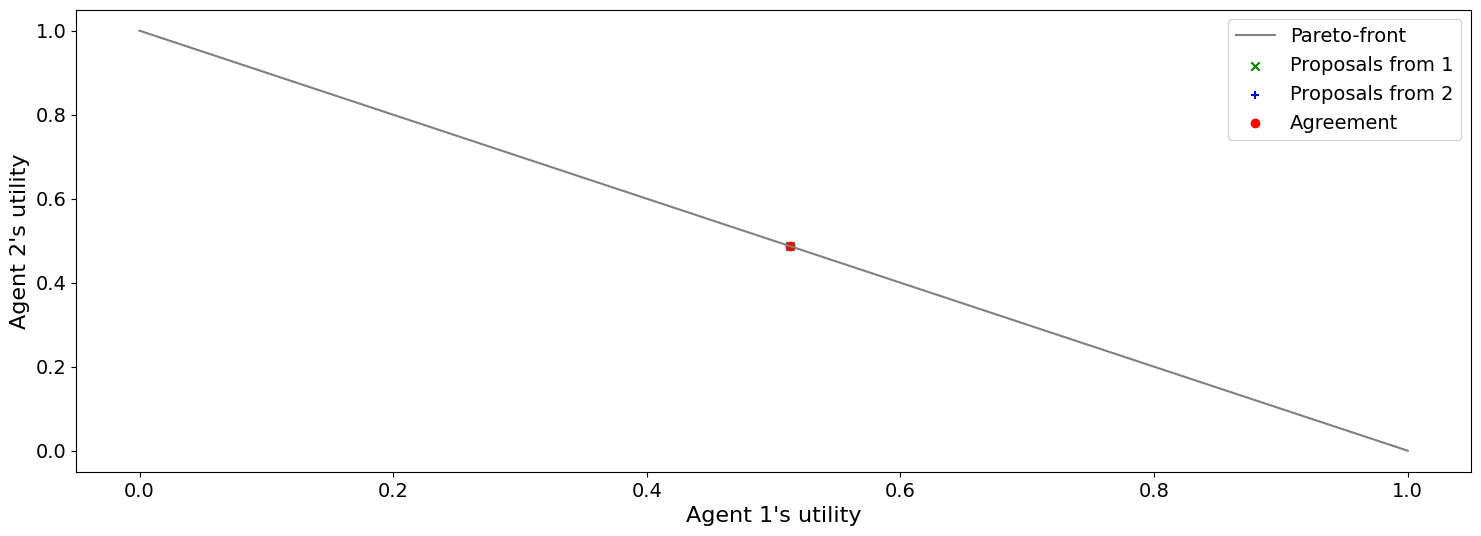

In [15]:
class OptimalRubinsteinNegotiator(RubinsteinNegotiator):
    def propose(
        self, state: RubinsteinMechanismState, dest: str | None = None
    ) -> Outcome:
        first = (1 - state.discounts[1]) / (1 - state.discounts[1] * state.discounts[0])
        return first, 1 - first


mechanism = RubinsteinMechanism()
mechanism.add(OptimalRubinsteinNegotiator())
mechanism.add(OptimalRubinsteinNegotiator())
print(f"Agreed to: {mechanism.run().agreement} in {mechanism.current_step} steps")
plot_a_run(mechanism)

We can see that even though both negotiators had the same time-pressure ($\delta_0 = \delta_1$)  and have the same
utility function, the negotiator that started, gets a higher utility at the equilibrium. 


Let's try to make an agent that does not use the information about the other agent's 

Agreed to: None in 100 steps


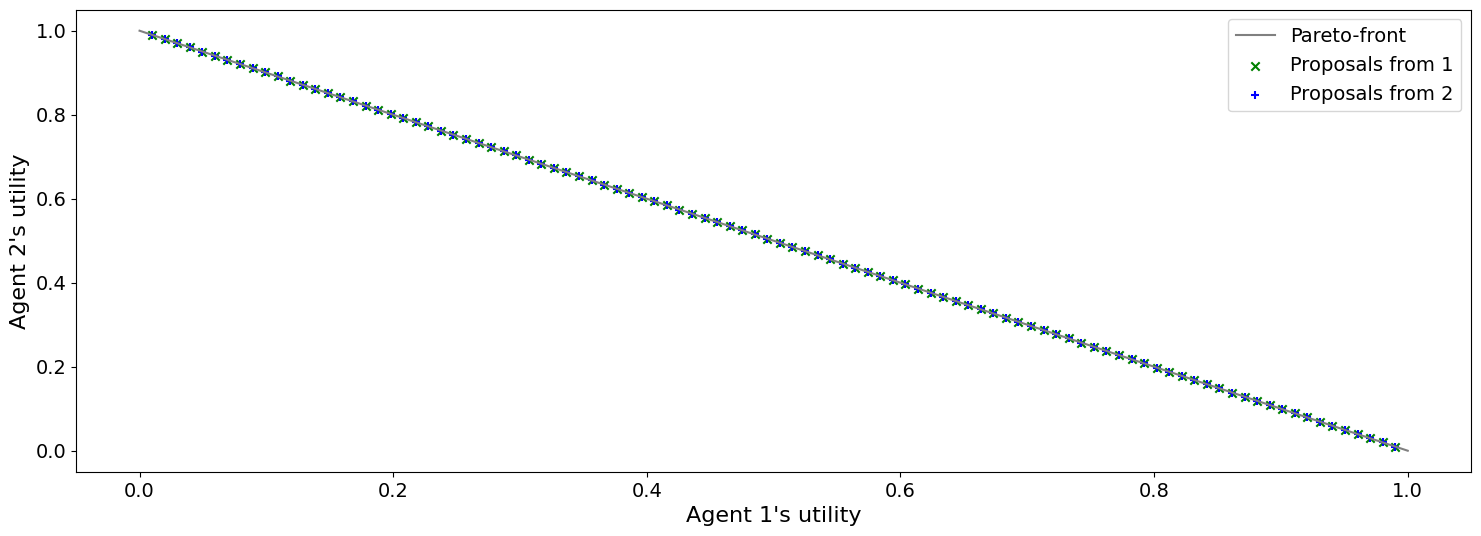

In [16]:
class AspirationRubinsteinNegotiator(RubinsteinNegotiator):
    def __init__(self, *args, aspiration_type="linear", max_aspiration=1.0, **kwargs):
        super().__init__(*args, **kwargs)
        self._asp = PolyAspiration(max_aspiration, aspiration_type)

    def propose(
        self, state: RubinsteinMechanismState, dest: str | None = None
    ) -> Outcome:
        if self.ufun((1.0, 1.0)) < 0.0:
            return None
        r = self._asp.utility_at(state.relative_time)
        return (r, 1.0 - r) if self.my_index == 0 else (1.0 - r, r)


mechanism = RubinsteinMechanism(n_steps=100)
mechanism.add(AspirationRubinsteinNegotiator())
mechanism.add(AspirationRubinsteinNegotiator())
result = mechanism.run()
print(f"Agreed to: {result.agreement} in {mechanism.current_step} steps")
plot_a_run(mechanism)

Now we can see when the first negotiator is a `conceder` :

Agreed to: (0.27438013387778515, 0.7227722772277227) in 28 steps


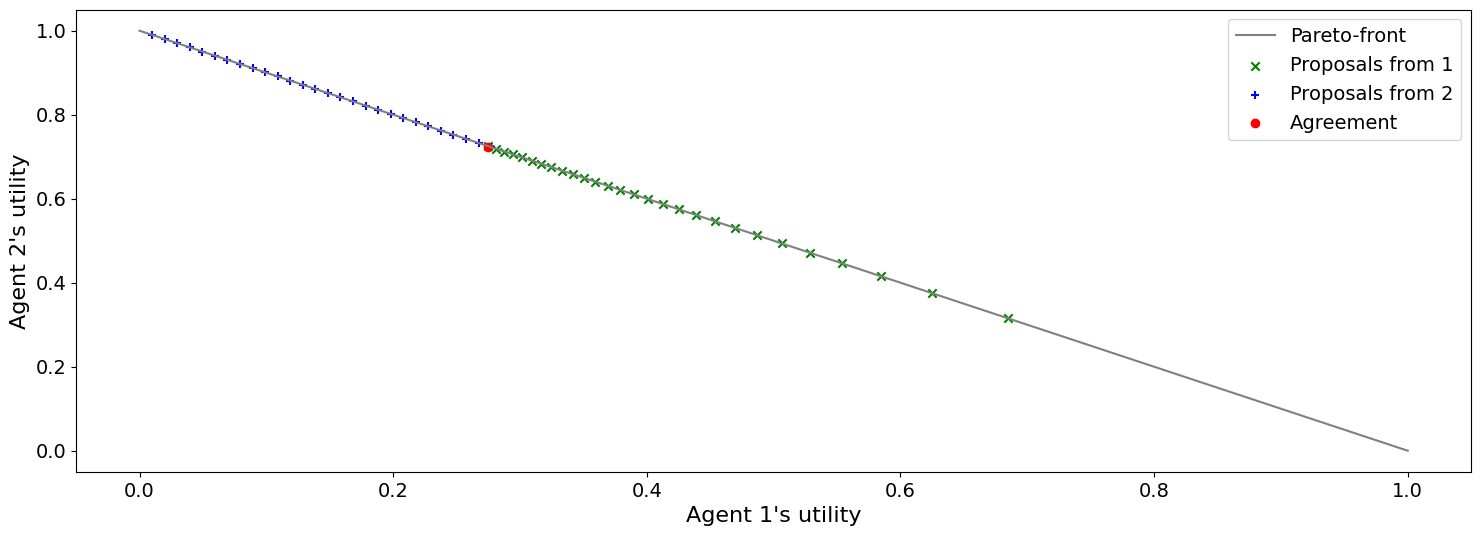

In [17]:
mechanism = RubinsteinMechanism(n_steps=100, extended=True)
mechanism.add(AspirationRubinsteinNegotiator(aspiration_type="conceder"))
mechanism.add(AspirationRubinsteinNegotiator())
print(f"Agreed to: {mechanism.run().agreement} in {mechanism.current_step} steps")
plot_a_run(mechanism)

As expected, the agreement shifted toward the second agent.

Now we can see when the first negotiator is a `bolware` (i.e. it concedes slowly in the beginning then fast near the end):

Agreed to: (0.7118348986565985, 0.26732673267326734) in 74 steps


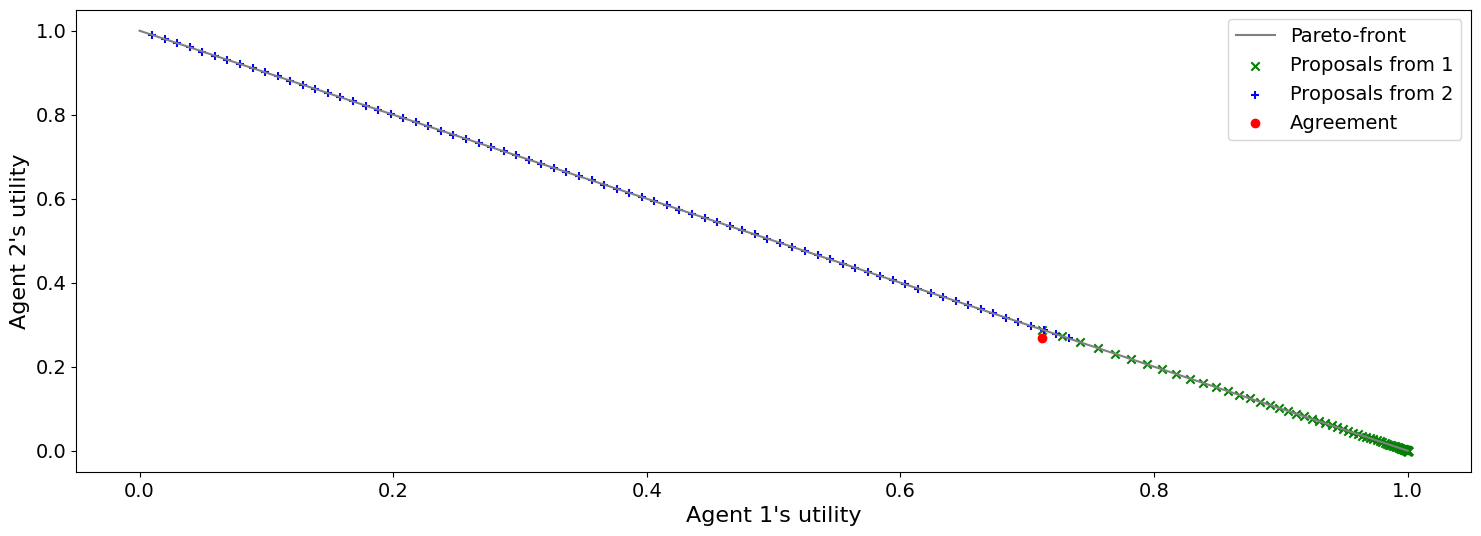

In [18]:
mechanism = RubinsteinMechanism(n_steps=100, extended=True)
mechanism.add(AspirationRubinsteinNegotiator(aspiration_type="boulware"))
mechanism.add(AspirationRubinsteinNegotiator())
print(f"Agreed to: {mechanism.run().agreement} in {mechanism.current_step} steps")
plot_a_run(mechanism)

As expected, the agreement shifted toward the second agent.

We can see now that the first agent is getting higher utility compared with when it did use the optimal negotiation behavior proved to be the equilibrium for this game by Rubinstein. Nevertheless, the second agent now notices that the first agent is conceding slower than itself and is expected to concede slowly itself to increase its utility leading to something like this:

Agreed to: (0.498362254052817, 0.498362254052817) in 85 steps


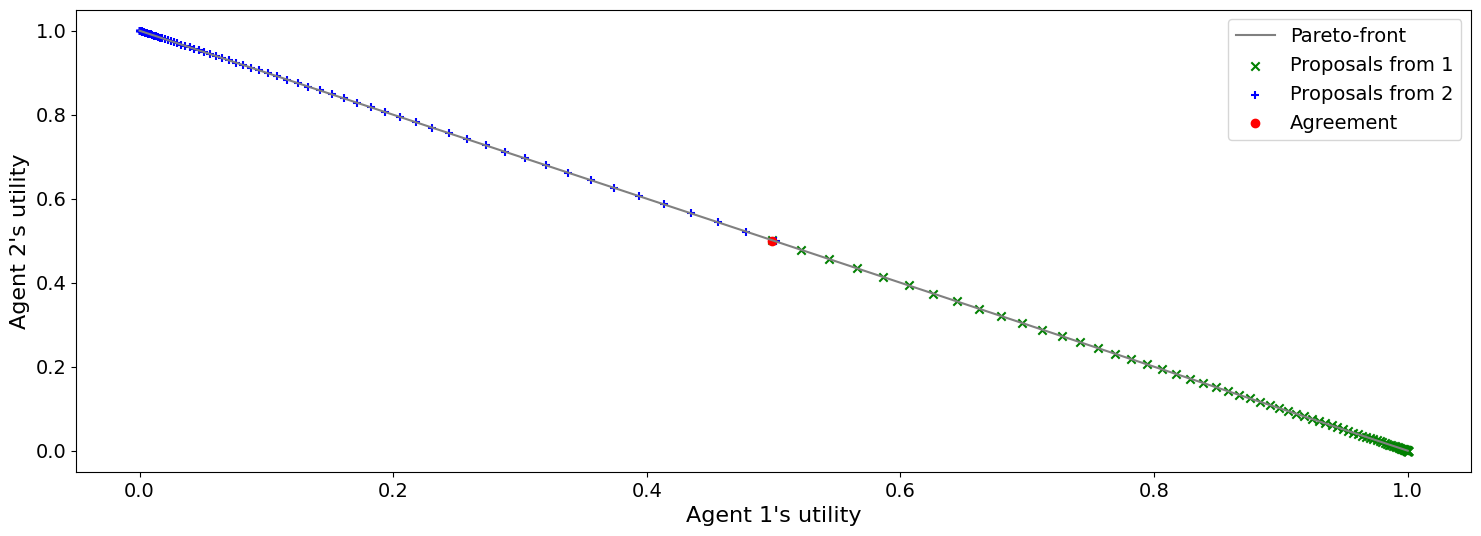

In [19]:
mechanism = RubinsteinMechanism(n_steps=100, extended=True)
mechanism.add(AspirationRubinsteinNegotiator(aspiration_type="boulware"))
mechanism.add(AspirationRubinsteinNegotiator(aspiration_type="boulware"))
print(f"Agreed to: {mechanism.run().agreement} in {mechanism.current_step} steps")
plot_a_run(mechanism)

Now we are back to the equilibirum achieved by the optimal negotiator in one stp but we needed many more steps to achieve it.

What if the discounts were different for the two negotiators? Let's try it:

Agreed to: (0.6896551724137928, 0.3103448275862072) in 1 steps


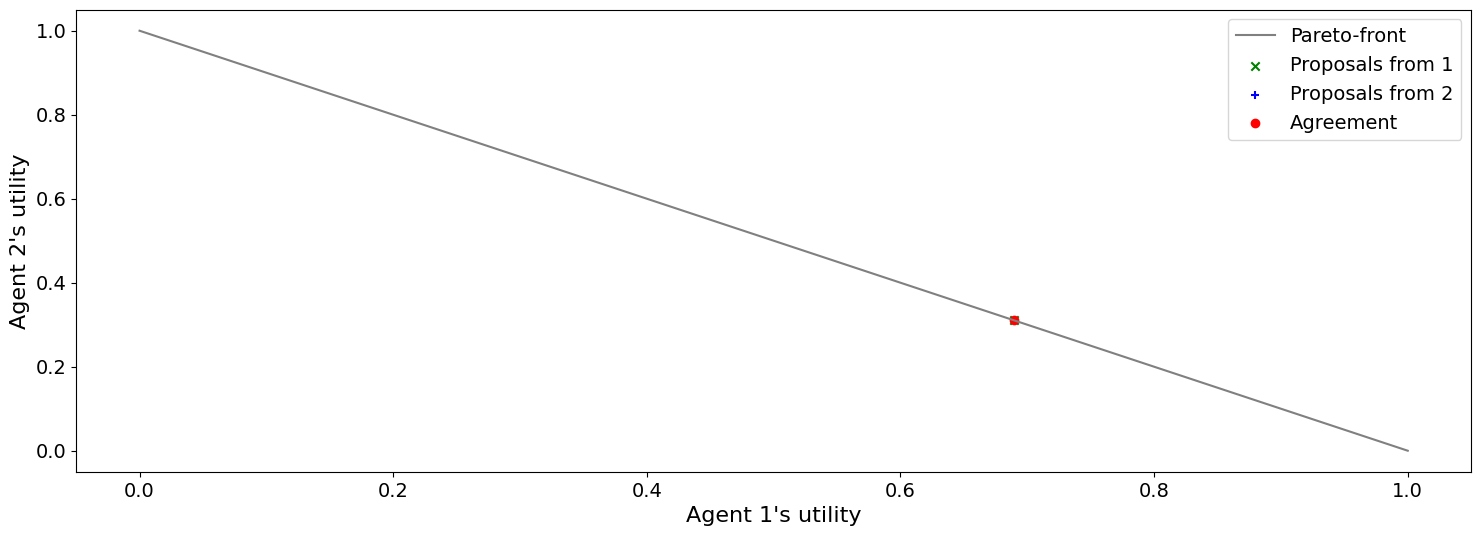

In [20]:
mechanism = RubinsteinMechanism()
mechanism.add(OptimalRubinsteinNegotiator(), discount=0.95)
mechanism.add(OptimalRubinsteinNegotiator(), discount=0.9)
print(f"Agreed to: {mechanism.run().agreement} in {mechanism.current_step} steps")
plot_a_run(mechanism)

A lower discount value indicates higher time pressure. This means that the second negotiator is under higher time pressure which is indicated in the first negotiator getting higher utility than before (i.e. the agreement shifts towards the agent with lower time pressure).

What if we tried our boulware here:

Agreed to: (0.498362254052817, 0.498362254052817) in 85 steps


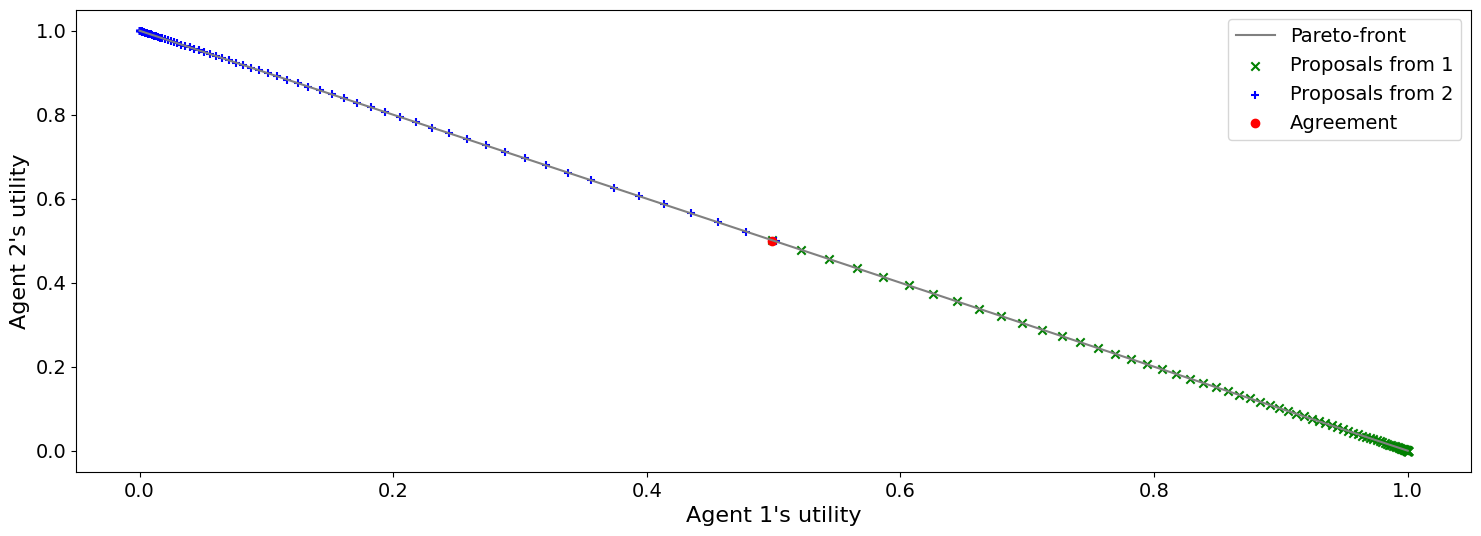

In [21]:
mechanism = RubinsteinMechanism(n_steps=100, extended=True)
mechanism.add(AspirationRubinsteinNegotiator(aspiration_type="boulware"), discount=0.95)
mechanism.add(AspirationRubinsteinNegotiator(aspiration_type="boulware"), discount=0.9)
print(f"Agreed to: {mechanism.run().agreement} in {mechanism.current_step} steps")
plot_a_run(mechanism)

The behavior did not change from the case with equal time pressure. There is no mystry here. The boulware agent does not take its own time-pressure (discount) into account. Can you fix that?